In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import mixed_precision

In [11]:
# Set mixed precision policy
mixed_precision.set_global_policy('mixed_float16')

# Define the path to the dataset
data_dir = 'KDEF'

In [12]:
# Preprocess image function
def preprocess_image(image_path, target_size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img

# Load dataset function
def load_dataset(data_dir, batch_size=32, target_size=(224, 224)):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=target_size,
        batch_size=batch_size,
        label_mode='categorical'
    )
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset

In [14]:
# Create the model
base_model = Sequential()
input_tensor=Input(shape=(224, 224, 3))
num_classes = 7  # Ensure this matches your dataset

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

ValueError: The layer sequential_2 has never been called and thus has no defined output.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to the dataset
train_dir = 'KDEF/train'
validation_dir = 'KDEF/validation'

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# List all subdirectories (emotions)
emotions = os.listdir(data_dir)

# Iterate over each emotion directory
for emotion in emotions:
    emotion_dir = os.path.join(data_dir, emotion)
    if os.path.isdir(emotion_dir):
        # List all image files in the emotion directory
        images = os.listdir(emotion_dir)
        images = [os.path.join(emotion_dir, img) for img in images if img.endswith('.jpg')]

        # Split the images into training and validation sets
        train_images, validation_images = train_test_split(images, test_size=0.2, random_state=42)

        # Create subdirectories for the current emotion in train and validation directories
        train_emotion_dir = os.path.join(train_dir, emotion)
        validation_emotion_dir = os.path.join(validation_dir, emotion)
        os.makedirs(train_emotion_dir, exist_ok=True)
        os.makedirs(validation_emotion_dir, exist_ok=True)

        # Move training images
        for img in train_images:
            shutil.move(img, train_emotion_dir)

        # Move validation images
        for img in validation_images:
            shutil.move(img, validation_emotion_dir)

print("Dataset split into training and validation sets successfully.")

In [5]:
# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the path to your training and validation data directories
train_data_dir = 'KDEF/train'
validation_data_dir = 'KDEF/validation'

# Define the generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Callbacks for learning rate reduction, early stopping, and model checkpointing
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Found 2938 images belonging to 7 classes.
Found 2938 images belonging to 7 classes.
Epoch 1/125


C:\Users\abdul\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 70s 703ms/step - accuracy: 0.1496 - loss: 1.9527 - val_accuracy: 0.1899 - val_loss: 1.9341
Epoch 2/125
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 0.9617 - val_accuracy: 0.3077 - val_loss: 0.9623
Epoch 3/125


C:\Users\abdul\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 366ms/step - accuracy: 0.1540 - loss: 1.9367 - val_accuracy: 0.2737 - val_loss: 1.9159
Epoch 4/125
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1250 - loss: 0.9830 - val_accuracy: 0.2308 - val_loss: 0.9589
Epoch 5/125
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 364ms/step - accuracy: 0.2144 - loss: 1.9230 - val_accuracy: 0.2370 - val_loss: 1.8931
Epoch 6/125
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 0.9565 - val_accuracy: 0.4615 - val_loss: 0.9167
Epoch 7/125
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 364ms/step - accuracy: 0.2072 - loss: 1.9052 - val_accuracy: 0.2867 - val_loss: 1.8446
Epoch 8/125
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1875 - loss: 0.9702 - val_accuracy: 0.2308 - val_loss: 0.9364
Epoch 9/125
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 365ms/step - accuracy: 0.2617 - loss: 1.8586 - val_accuracy: 0.4093 - val_loss: 1.7744
Epoch 10/125
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1562 - loss: 0.9455 - val_accuracy: 0.5385 - 

In [6]:
# Evaluate the model
model.load_weights('best_model.keras')
scores = model.evaluate(validation_generator, verbose=1)
print("Accuracy: ", scores[1])

92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.7468 - loss: 0.6822
Accuracy:  0.7552757263183594


In [7]:
# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(validation_generator, steps=len(validation_generator))
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

print('Classification Report')
cr = classification_report(y_true=y_true, y_pred=y_pred, target_names=list(validation_generator.class_indices.keys()))
print(cr)

92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14       420
     disgust       0.12      0.13      0.12       420
        fear       0.16      0.19      0.17       420
       happy       0.16      0.16      0.16       420
     neutral       0.12      0.11      0.11       420
         sad       0.17      0.09      0.12       419
    surprise       0.15      0.19      0.17       419

    accuracy                           0.14      2938
   macro avg       0.15      0.14      0.14      2938
weighted avg       0.15      0.14      0.14      2938



92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step


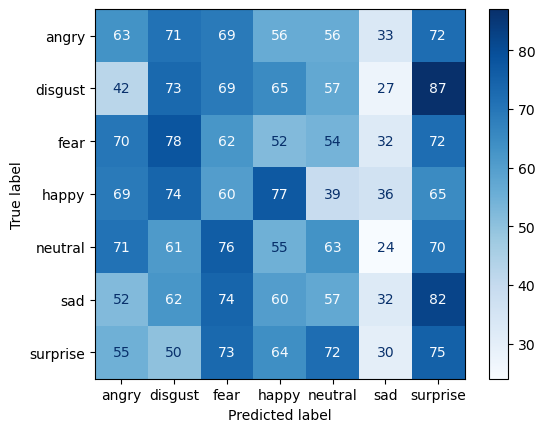

In [8]:
cm = confusion_matrix(y_true, y_pred)
labels = list(validation_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [9]:
import seaborn as sns

C:\Users\abdul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


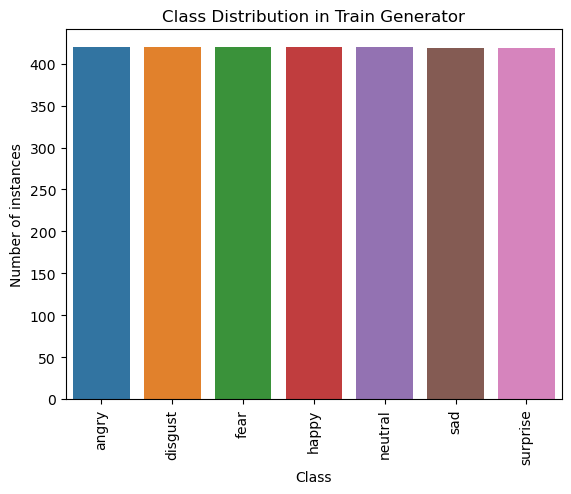

In [10]:
class_indices = train_generator.classes
unique_classes, instances_count = np.unique(class_indices, return_counts=True)

# Convert class indices back to class names
class_names = [list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(i)] for i in unique_classes]

sns.barplot(x=class_names, y=instances_count)
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Class Distribution in Train Generator')
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Predicted Emotion: disgust


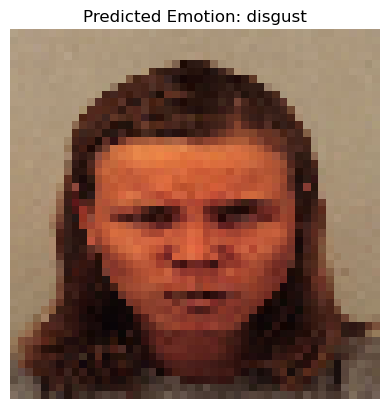

In [11]:
# Predict and display an image
def predict_and_display(image_path):
    original_img, img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    predicted_label = class_labels[predicted_index]
    print(f"Predicted Emotion: {predicted_label}")
    plt.imshow(original_img)
    plt.title(f"Predicted Emotion: {predicted_label}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Emotion: disgust


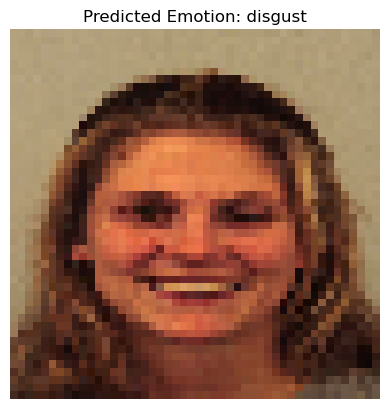

In [12]:
predict_and_display('PrivateTest_20588149.jpg')
predict_and_display('PrivateTest_16345756.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Emotion: disgust


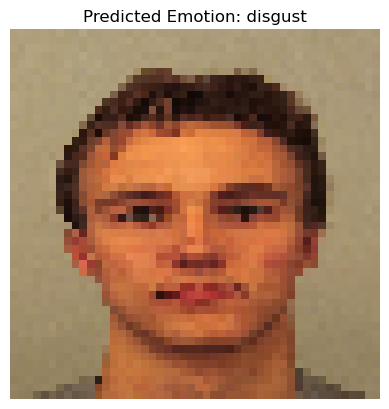

In [14]:
#Add prediction for one more facaial image 

In [15]:
model.save('facial_emotion_recognition_model.h5')